In [2]:
import numpy as np
import pandas as pd
import spacy
from itertools import product
from functools import reduce
from gensim.models import Word2Vec
import re
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB

In [4]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.layers import LSTM, GRU, GlobalMaxPool1D, Conv1D, MaxPooling1D, Activation
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

/home/vaden4d/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
nlp = spacy.load('en', parser=False)

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
#classes dictribution
train.groupby('author').agg({'text': 'count'})
# so they have almost uniform distribution

,text
author,
EAP,7900
HPL,5635
MWS,6044


In [9]:
words = train.text.str.split(expand=True).unstack().value_counts()

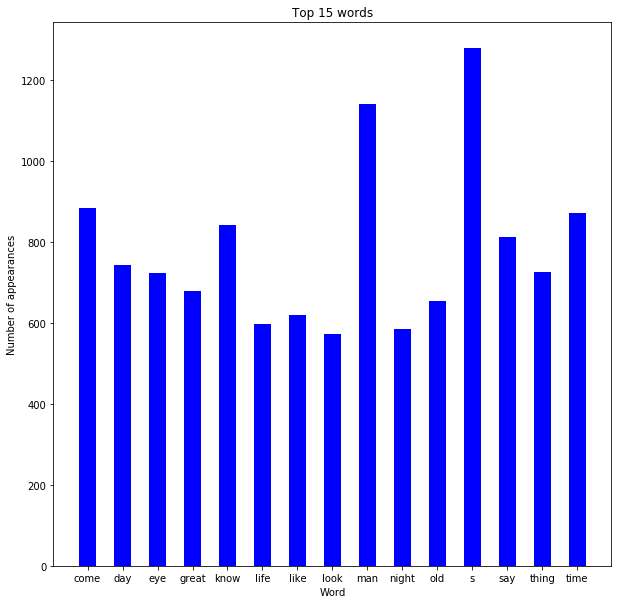

In [28]:
#plot the most popular words in the train texts
n = 15

bins = words[:n].index.values
values = words[:n].values

plt.figure(figsize=(10, 10))
plt.bar(bins, values, width=0.5, color='b', label='Top {x} words'.format(x=n))
plt.xlabel('Word')
plt.ylabel('Number of appearances')
plt.title('Top {x} words'.format(x=n))
plt.show()

# Preprocessing steps and generating some features

In [18]:
#some functions for language cleaning

def stopwords_count(sentence, nlp=nlp):
    '''Count stopwords'''
    doc = nlp(sentence)
    count = 0
    for token in doc:
        if str(token) in spacy.en.STOPWORDS:
            count +=1
    return count

def regex_preprocessing(data, lemmatization=True):
    '''Easy text cleaning via regex and lemmatization'''
    '''Cleaning of the dataframe with .text column'''
    if lemmatization:
        data.text = data.text.apply(lemmatize_text)
    #clear all non-alphabetic symbols and tabulation symbols near borders of sentence
    data.text = data.text.apply(lambda x: re.sub(r'[^A-Za-z]{1,}', ' ', x))
    data.text = data.text.apply(lambda x: re.sub(r'^\s|\s$', '', x))
    return data

def lemmatize_text(text, nlp=nlp):
    '''Lemmatize sentence and delete stopwords'''
    res = []
    doc = nlp(text)
    for token in doc:
        if str(token) not in spacy.en.STOPWORDS:
            res.append(token.lemma_)
    res = ' '.join(res)
    return res

def delete_rare_words(texts, min_freq=1, tag=True):
    vectorizer = CountVectorizer()
    vectorizer.fit(texts)
    vocab = vectorizer.vocabulary_
                
    text_splitted = list(map(lambda x: x.split(), texts))
    for i, sentence in enumerate(text_splitted):
        for j, word in enumerate(sentence):
            if min_freq > vocab[word]:
                if tag:
                    text_splitted[i][j] = '<UNK>'
                else:
                    text_splitted[i][j] = ''
    return text_splitted, vectorizer

In [19]:
#init filtering
train = train.fillna('filledna')
test = test.fillna('filledna')

train.text = train.text.apply(lambda x: x.lower())
test.text = test.text.apply(lambda x: x.lower())

In [20]:
#add new linguistic features

#words count
train['n_words'] = train.text.apply(lambda x: len(x.split())) 
test['n_words'] = test.text.apply(lambda x: len(x.split()))

#unique words count
train['n_u_words'] = train.text.apply(lambda x: len(np.unique(x.split())))
test['n_u_words'] = test.text.apply(lambda x: len(np.unique(x.split())))

#stop words count
train['n_stopwords'] = train.text.apply(stopwords_count)
test['n_stopwords'] = test.text.apply(stopwords_count)

train = train[['id', 'text', 'n_words', 'n_u_words', 'n_stopwords', 'author']]
test = test[['id', 'text', 'n_words', 'n_u_words', 'n_stopwords']]

In [21]:
#min max scaler for new features 
scaler = MinMaxScaler()
scaler.fit(train[['n_words', 'n_u_words', 'n_stopwords']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
train[['n_words', 'n_u_words', 'n_stopwords']] = scaler.transform(train[['n_words', 'n_u_words', 'n_stopwords']])
test[['n_words', 'n_u_words', 'n_stopwords']] = scaler.transform(test[['n_words', 'n_u_words', 'n_stopwords']])

In [23]:
train_preprocessed = regex_preprocessing(train)
test_preprocessed = regex_preprocessing(test)

In [25]:
# delete sentences with all stop words 

# there are exist sentences with only stop words (near 20 sentences), so after cleaning they are empty
# I decided to delete this sentences, because now I don't know what I must to do with this sentences 

train_preprocessed = train_preprocessed.loc[train_preprocessed.text.apply(lambda x: len(x)) > 1]
train_preprocessed = pd.concat([train_preprocessed, pd.get_dummies(train_preprocessed.author)], axis=1)

test_preprocessed = test_preprocessed.loc[test_preprocessed.text.apply(lambda x: len(x)) > 1]

train_texts = train_preprocessed.text.values
train_labels = train_preprocessed.iloc[:, -3:].values

test_texts = test_preprocessed.text.values

In [145]:
all_texts = np.concatenate([train_texts, test_texts])

In [26]:
#tokenize texts - some model used list of strs, but some list of lists with words as string (w2v gensim)

tokenized_train_texts = list(map(lambda x: x.split(), train_texts))
tokenized_test_texts = list(map(lambda x: x.split(), test_texts))

tokenized_all_texts = tokenized_train_texts + tokenized_test_texts

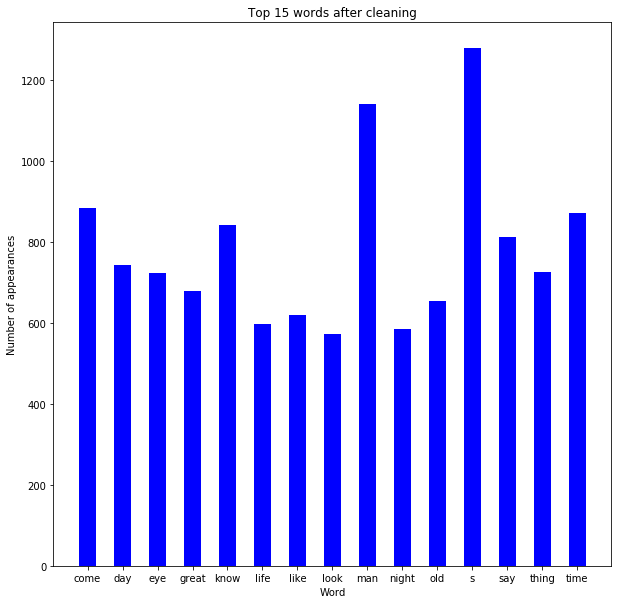

In [29]:
words = train_preprocessed.text.str.split(expand=True).unstack().value_counts()

n = 15

bins = words[:n].index.values
values = words[:n].values

plt.figure(figsize=(10, 10))
plt.bar(bins, values, width=0.5, color='b', label='Top {x} words'.format(x=n))
plt.xlabel('Word')
plt.ylabel('Number of appearances')
plt.title('Top {x} words after cleaning'.format(x=n))
plt.show()

# Word2Vec

## This texts have own specific style (because they are books of famous writers), so I've trained my own vectors on this documents.

In [30]:
model = Word2Vec(tokenized_train_texts, min_count=1)
model.train(tokenized_train_texts, total_examples=len(tokenized_train_texts), epochs=10)

(2234975, 2255960)

In [31]:
def sentence_vector(texts, w2v_model=model):
    '''For every sentence returns its vector representation = 
    mean of all word vectors in the sentence'''
    sentence_matrix = []
    for sentence in texts:
        tmp = np.zeros(w2v_model.vector_size)
        for word in sentence:
            try:
                tmp += w2v_model[word]
            except KeyError:
                print('{x} not in dictionary, sorry!'.format(x=word))
        tmp /= len(sentence)
        sentence_matrix.append(tmp)
    sentence_matrix = np.array(sentence_matrix)
    return sentence_matrix

In [32]:
X = sentence_vector(tokenized_train_texts)

/home/vaden4d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [42]:
#also added new features to w2v-matrix
X1 = np.c_[X, train_preprocessed[['n_words', 'n_u_words', 'n_stopwords']].values]

In [33]:
#visualize features in the compressed 2D space via PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

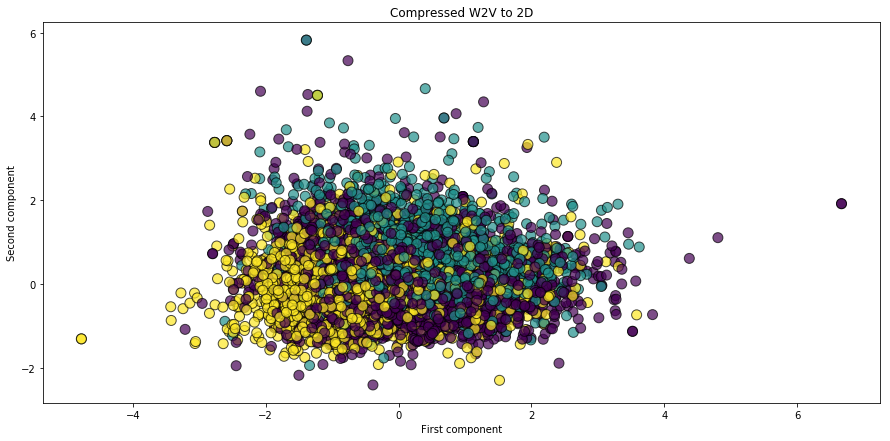

In [35]:
plt.figure(figsize=(15, 7))
plt.scatter(result[:, 0], result[:, 1], c=train_labels.argmax(axis=1), 
            alpha=0.7, 
            s=100, 
            edgecolors='black', 
            linewidth=1.0)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Compressed W2V to 2D')
plt.show()
# so we can see that with w2v meaned vectors sentences of different authors can be lineary separable 
# (but one author has like uniform distribution of the vectors in 2d space)

# tf idf vectors

In [36]:
#build also TfIdf vectors for sentences
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(train_texts)

#transform from vectorizer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [37]:
#special SVD for sparse matrix
svd = TruncatedSVD(n_components=2)
result = svd.fit_transform(X_train_tfidf)

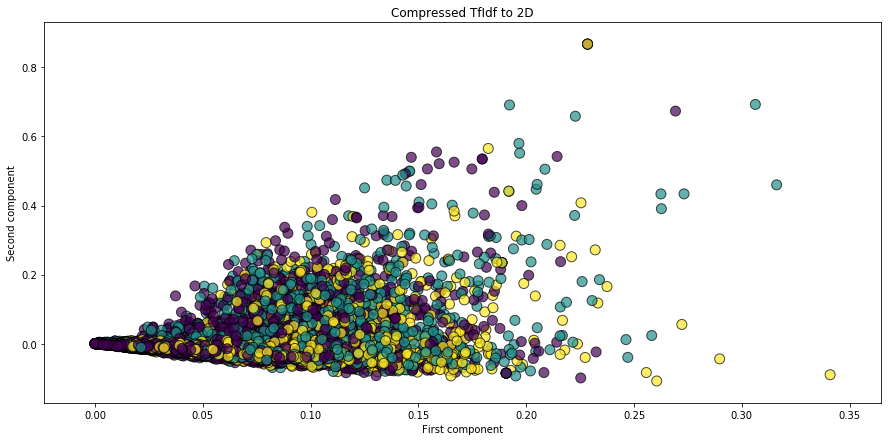

In [38]:
plt.figure(figsize=(15, 7))
plt.scatter(result[:, 0], result[:, 1], c=train_labels.argmax(axis=1), 
            alpha=0.7, 
            s=100, 
            edgecolors='black', 
            linewidth=1.0)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Compressed TfIdf to 2D')
plt.show()
# so we can see that TfIdf doesn't lineary separable (on the first view)

## Logistic regression with word2vec for sentence and tfidf vectors

In [50]:
# the simplest continuous classificator ever, so I will use it 

In [43]:
#beatiful confusion matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize: 
            element = cm[i, j] / cm.sum()
            element = np.around(element, 3)
        else: 
            element = cm[i, j]
        plt.text(j, i, element,
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
classes = train_preprocessed.iloc[:, -3:].columns

### word2vec 

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X1, train_labels.argmax(axis=1), test_size=0.33, random_state=42)

In [120]:
# c - regularization parameter
tuned_parameters = {
                    'penalty': ['l1', 'l2'],
                    'C': [0.1, 1],
                   }

In [121]:
# cross validation grid search of the logistic regression - find the best params of model via
# minimal mean on the test data (test_1 + ... test_cv / cv)

#loss function - cross-entropy (in sklearn it is neg_los_loss)
obj = GridSearchCV(LogisticRegression(), 
                   tuned_parameters, 
                   cv=5,
                   scoring='neg_log_loss')
obj.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [122]:
best_model = obj.best_estimator_

In [123]:
best_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [124]:
print('Accuracy: {x}'.format(x=accuracy_score(y_test, best_model.predict(X_test))))
print('Recall: {x}'.format(x=recall_score(y_test, best_model.predict(X_test), average='weighted')))
print('Precision: {x}'.format(x=precision_score(y_test, best_model.predict(X_test), average='weighted')))

Accuracy: 0.6728146311221327
Recall: 0.6728146311221327
Precision: 0.674990342055755


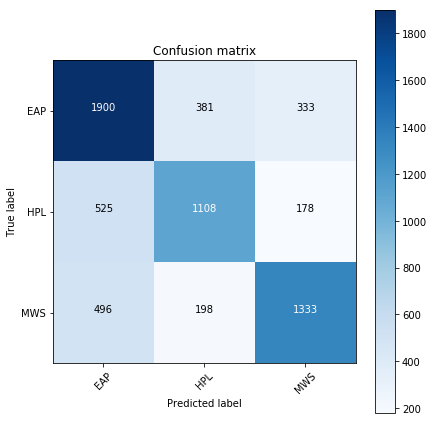

In [125]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(confusion_matrix(y_test, best_model.predict(X_test)), classes)
plt.show()
# so we can see that logistic regression doesn't work well enough with meaned w2v of words
# okay..

### tfidf

In [126]:
count_vect = CountVectorizer()
train_texts_counts = count_vect.fit_transform(train_texts)
tfidf_transformer = TfidfTransformer()
train_texts_tfidf = tfidf_transformer.fit_transform(train_texts_counts)

X_train, X_test, y_train, y_test = train_test_split(train_texts_tfidf, train_labels.argmax(axis=1), random_state=42)
# I used there only text features, because there are sparse matrix object, so I tried
# to compress TfIdf matrix into smaller, but with this method results were very very bad

In [127]:
tuned_parameters = {
                    'penalty': ['l1', 'l2'],
                    'C': [0.01, 0.1, 0.5, 1],
                   }

In [128]:
obj = GridSearchCV(LogisticRegression(), 
                   tuned_parameters, 
                   cv=5,
                   scoring='neg_log_loss')
obj.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [129]:
best_model = obj.best_estimator_

In [130]:
best_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [131]:
print('Accuracy: {x}'.format(x=accuracy_score(y_test, best_model.predict(X_test))))
print('Recall: {x}'.format(x=recall_score(y_test, best_model.predict(X_test), average='weighted')))
print('Precision: {x}'.format(x=precision_score(y_test, best_model.predict(X_test), average='weighted')))

Accuracy: 0.8064648117839607
Recall: 0.8064648117839607
Precision: 0.8117223038088137


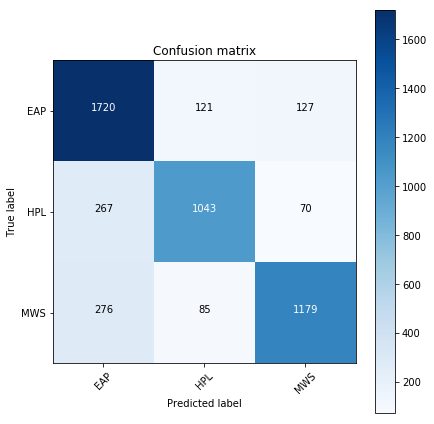

In [132]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(confusion_matrix(y_test, best_model.predict(X_test)), classes)
plt.show()
# not bad!

## Multinomial Naive bayes with tfidf

In [165]:
count_vect = CountVectorizer()
train_texts_counts = count_vect.fit_transform(train_texts)
tfidf_transformer = TfidfTransformer()
train_texts_tfidf = tfidf_transformer.fit_transform(train_texts_counts)

X_train, X_test, y_train, y_test = train_test_split(train_texts_tfidf, train_labels.argmax(axis=1), random_state=42)

In [166]:
tuned_parameters = {
                    'alpha': [0.01, 0.2, 0.5, 1],
                   }

In [167]:
obj = GridSearchCV(MultinomialNB(), 
                   tuned_parameters, 
                   cv=5,
                   scoring='neg_log_loss')
obj.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.2, 0.5, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [168]:
best_model = obj.best_estimator_

In [169]:
#retrain
best_model.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [170]:
print('Accuracy: {x}'.format(x=accuracy_score(y_test, best_model.predict(X_test))))
print('Recall: {x}'.format(x=recall_score(y_test, best_model.predict(X_test), average='weighted')))
print('Precision: {x}'.format(x=precision_score(y_test, best_model.predict(X_test), average='weighted')))

Accuracy: 0.8316284779050737
Recall: 0.8316284779050737
Precision: 0.8316376674197822


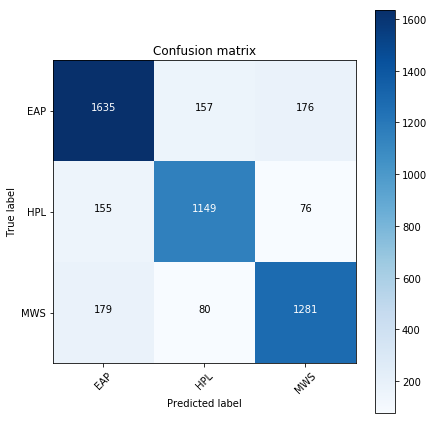

In [171]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(confusion_matrix(y_test, best_model.predict(X_test)), classes)
plt.show()
# the best result!
# matrix became more diagonal - has higher capability for true classification

### Submission

In [172]:
# as writed in the .txt, I predict test labels
# my the best model - Naive bayes, so I create tfidf vectors with all data (test + train)
# train on all train data (because model can generalize good)

In [173]:
count_vect = CountVectorizer()
all_texts_counts = count_vect.fit_transform(all_texts)
tfidf_transformer = TfidfTransformer()
all_texts_tfidf = tfidf_transformer.fit_transform(all_texts_counts)

In [174]:
#as all_text = [train, test], so divide by train_texts.shape
full_train = all_texts_tfidf[:train_texts.shape[0]]
full_labels = train_labels.argmax(axis=1)

In [147]:
best = MultinomialNB(alpha=0.01)

In [175]:
best.fit(full_train, full_labels)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [183]:
test_predicted = best.predict(all_texts_tfidf[train_texts.shape[0]:])

In [187]:
submission = test[['id', 'text']].copy()
submission.loc[test_preprocessed.index, 'author'] = test_predicted 

emtpy_texts_index = submission.loc[submission.isnull().any(axis=1)].index
submission.loc[emtpy_texts_index, 'author'] = np.random.randint(1, 3, size=len(emtpy_texts_index))

classes = {0.0: 'EAP', 1.0: 'HPL', 2.0: 'MWS'}
submission.author = submission.author.map(classes)
submission.to_csv('submission.csv', index=False)

# Dense with w2v of sentences

In [70]:
# try to build neural network with only w2v sentences 

In [157]:
def dense_model(model=model):
    # only dense architecture
    inp = Input(shape=(model.vector_size,))
    
    x = Dense(70)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(30)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    x = Dense(10)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    x = Dense(3, activation='softmax')(x)
    neural_network = Model(inputs=inp, outputs=x)
    neural_network.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return neural_network

In [158]:
dense_nn = dense_model()
dense_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 70)                7070      
_________________________________________________________________
batch_normalization_14 (Batc (None, 70)                280       
_________________________________________________________________
activation_14 (Activation)   (None, 70)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 30)                2130      
_________________________________________________________________
batch_normalization_15 (Batc (None, 30)                120       
_________________________________________________________________
activation_15 (Activation)   (None, 30)                0         
__________

In [159]:
batch_size = 32
epochs = 10

In [160]:
file_path='best_dense.hdf5'

#create some usefull callbacks
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=20)

callbacks_list = [checkpoint, early] 

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.2, random_state=42)

In [162]:
dense_nn.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test), callbacks=callbacks_list)

Train on 15640 samples, validate on 3911 samples
Epoch 1/10
15640/15640 [==============================] - 9s 557us/step - loss: 0.8563 - acc: 0.6103 - val_loss: 0.7934 - val_acc: 0.6507

Epoch 00001: val_loss improved from inf to 0.79335, saving model to best_dense.hdf5
Epoch 2/10
15640/15640 [==============================] - 8s 519us/step - loss: 0.8162 - acc: 0.6357 - val_loss: 0.7911 - val_acc: 0.6497

Epoch 00002: val_loss improved from 0.79335 to 0.79105, saving model to best_dense.hdf5
Epoch 3/10
15640/15640 [==============================] - 8s 514us/step - loss: 0.8022 - acc: 0.6426 - val_loss: 0.7941 - val_acc: 0.6413

Epoch 00003: val_loss did not improve
Epoch 4/10
15640/15640 [==============================] - 8s 540us/step - loss: 0.7987 - acc: 0.6418 - val_loss: 0.8057 - val_acc: 0.6397

Epoch 00004: val_loss did not improve
Epoch 5/10
15640/15640 [==============================] - 8s 523us/step - loss: 0.7901 - acc: 0.6510 - val_loss: 0.7862 - val_acc: 0.6484

Epoch 00

In [ ]:
# so conclusion is that dense model doesn't train pretty well

### It doesn't look very well. But what about RNN with w2v-sequences?

# RNN

In [71]:
max_len = 80

In [72]:
# write generator, because it is very hard to save all this data into RAM
def generator(data, labels, batch_size, model=model, max_len=max_len):
    '''Generate word2vec matrices from few sentences and stack it together
    into one tensor'''
    while True:
        n_batches = np.ceil(len(data) / batch_size).astype('int')
        for i in range(n_batches):
            tensor = []
            
            #get batch and labels
            batch = data[i*batch_size:(i+1)*batch_size]
            batch_labels = labels[i*batch_size:(i+1)*batch_size]
            
            #get list of matrices with size (n_words, w2v_size)
            for sentence in batch:
                matrix = []
                for word in sentence:
                    matrix.append(model[word])
                tensor.append(matrix)
            #pad sequence of matrices to one format: (batch_size, max_len, w2v_size)
            tensor = sequence.pad_sequences(tensor, max_len, padding='post', dtype='float64')
            yield tensor, batch_labels

In [73]:
def get_model(model=model):
    inp = Input(shape=(max_len, model.vector_size))
    x = LSTM(300, return_sequences=True)(inp)
    x = GlobalMaxPool1D()(x)
    
    x = Dropout(0.1)(x)
    x = Dense(15, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3, activation='softmax')(x)
    neural_network = Model(inputs=inp, outputs=x)
    neural_network.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return neural_network

In [74]:
nn = get_model()

In [75]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80, 300)           481200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                4515      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15)                60        
__________

In [76]:
batch_size = 16
epochs = 20

In [77]:
file_path='best_rnn.hdf5'

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=20)

callbacks_list = [checkpoint, early] 

In [104]:
# for neural networks now I can't do cross validation, because it takes a lot of time and 
# resources of my computer too, so will be train-test only

X_train, X_test, y_train, y_test = train_test_split(tokenized_train_texts, train_labels, test_size=0.33, random_state=42)

In [79]:
train_gen = generator(X_train, y_train, batch_size)
test_gen = generator(X_test, y_test, batch_size)

In [80]:
nn.fit_generator(train_gen, 
                epochs=epochs,
                steps_per_epoch=len(X_train)//batch_size,
                validation_data=test_gen,
                callbacks=callbacks_list,
                validation_steps=len(X_test)//batch_size)

/home/vaden4d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch 1/20
818/818 [==============================] - 169s 207ms/step - loss: 0.9532 - acc: 0.5561 - val_loss: 1.0665 - val_acc: 0.5146

Epoch 00001: val_loss improved from inf to 1.06651, saving model to best_rnn.hdf5
Epoch 2/20
818/818 [==============================] - 154s 189ms/step - loss: 0.8494 - acc: 0.6231 - val_loss: 0.8082 - val_acc: 0.6450

Epoch 00002: val_loss improved from 1.06651 to 0.80816, saving model to best_rnn.hdf5
Epoch 3/20
818/818 [==============================] - 163s 200ms/step - loss: 0.7981 - acc: 0.6529 - val_loss: 0.7293 - val_acc: 0.6844

Epoch 00003: val_loss improved from 0.80816 to 0.72926, saving model to best_rnn.hdf5
Epoch 4/20
818/818 [==============================] - 165s 201ms/step - loss: 0.7593 - acc: 0.6710 - val_loss: 0.7263 - val_acc: 0.6760

Epoch 00004: val_loss improved from 0.72926 to 0.72627, saving model to best_rnn.hdf5
Epoch 5/20
818/818 [==============================] - 166s 202ms/step - loss: 0.7344 - acc: 0.6872 - val_loss: 0

KeyboardInterrupt: 

In [105]:
test_tensor, y_real = next(generator(X_test, y_test, len(y_test)))

/home/vaden4d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [110]:
y_pred = nn.predict(test_tensor)

In [116]:
y_real = y_real.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

In [117]:
print('Accuracy: {x}'.format(x=accuracy_score(y_real, y_pred)))
print('Recall: {x}'.format(x=recall_score(y_real, y_pred, average='weighted')))
print('Precision: {x}'.format(x=precision_score(y_real, y_pred, average='weighted')))

Accuracy: 0.6608803471791692
Recall: 0.6608803471791692
Precision: 0.7287490838781766


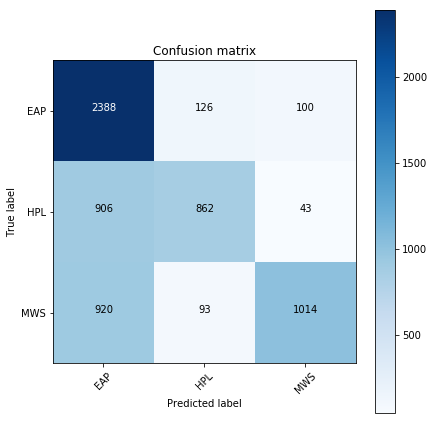

In [118]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(confusion_matrix(y_real, y_pred), classes)
plt.show()
# not good :c

In [214]:
#logs for model with 600 units in LTSM - model overfitted, it's good too - better than underfit
nn.fit_generator(train_gen, 
                epochs=epochs,
                steps_per_epoch=len(X_train)//batch_size,
                validation_data=test_gen,
                callbacks=callbacks_list,
                validation_steps=len(X_test)//batch_size)

/home/vaden4d/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch 1/20
818/818 [==============================] - 256s 313ms/step - loss: 0.9127 - acc: 0.5783 - val_loss: 0.8559 - val_acc: 0.6016

Epoch 00001: val_loss improved from inf to 0.85588, saving model to best_rnn.hdf5
Epoch 2/20
818/818 [==============================] - 241s 295ms/step - loss: 0.8380 - acc: 0.6264 - val_loss: 0.7362 - val_acc: 0.6832

Epoch 00002: val_loss improved from 0.85588 to 0.73624, saving model to best_rnn.hdf5
Epoch 3/20
818/818 [==============================] - 250s 305ms/step - loss: 0.7821 - acc: 0.6578 - val_loss: 0.9019 - val_acc: 0.5875

Epoch 00003: val_loss did not improve
Epoch 4/20
818/818 [==============================] - 252s 308ms/step - loss: 0.7504 - acc: 0.6756 - val_loss: 0.7377 - val_acc: 0.6802

Epoch 00004: val_loss did not improve
Epoch 5/20
818/818 [==============================] - 250s 306ms/step - loss: 0.7253 - acc: 0.6919 - val_loss: 0.6975 - val_acc: 0.7039

Epoch 00005: val_loss improved from 0.73624 to 0.69750, saving model to

## Conclusion

### The best models - Naive bayes and TfIdf + Tuned logistic regression
### Word2Vec demostrated more worse results that TfIdf, but with new features accuracy was increased (0.6 -> 0.67 - you can test it, if train model with X and X1 matrices)

### Hypothetical improvements:
    ### Clean texts again - in the texts exists the most popular word - 's'. It's artefact after lemmatization and
    regex cleaning (It's -> It s -> s)
    ### Also train word2vec on all corpus (not only train text, as I did, but for Naive bayes I trained on the
    all texts - for test prediction)
    ### Add other features to w2v to and maybe compress it (via PCA)
    ### Build smaller RNN - my the last model has 400k params - space number. With 1M params RNN was overfitted on     the data, so optimal model has <1M params